# Tree based classification/regression

## Load librairies

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, f1_score
from sklearn import preprocessing
from category_encoders import *
from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image
#from src.utils import plot_validation_results, plot_scores

## Load Dataset

In [165]:
dataset = pd.read_csv('TMBD Movie Dataset.csv')
dataset = dataset.reset_index()
pd.set_option('display.max_columns', None)
dataset = dataset.loc[dataset["popularity_level"].isna() == False]
print(dataset.shape)

(1286, 25)


In [166]:
dataset = dataset.loc[dataset["popularity_level"].isna() == False]

In [92]:
dataset.head(5)

,index,Unnamed: 0,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,keywords,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj,profit,popularity_level
0,0,0,135397,tt0369610,32.985763,150000000.0,1.513529e+09,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,monster|dna|tyrannosaurus rex|velociraptor|island,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,2015-06-09,5562,6.5,2015,1.379999e+08,1.392446e+09,1.363529e+09,High
1,1,1,76341,tt1392190,28.419936,150000000.0,3.784364e+08,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,future|chase|post-apocalyptic|dystopia|australia,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,2015-05-13,6185,7.1,2015,1.379999e+08,3.481613e+08,2.284364e+08,High
2,2,2,262500,tt2908446,13.112507,110000000.0,2.952382e+08,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,based on novel|revolution|dystopia|sequel|dyst...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,2015-03-18,2480,6.3,2015,1.012000e+08,2.716190e+08,1.852382e+08,High
3,3,3,140607,tt2488496,11.173104,200000000.0,2.068178e+09,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,http://www.starwars.com/films/star-wars-episod...,J.J. Abrams,Every generation has a story.,android|spaceship|jedi|space opera|3d,Thirty years after defeating the Galactic Empi...,136,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,2015-12-15,5292,7.5,2015,1.839999e+08,1.902723e+09,1.868178e+09,High
4,4,4,168259,tt2820852,9.335014,190000000.0,1.506249e+09,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,http://www.furious7.com/,James Wan,Vengeance Hits Home,car race|speed|revenge|suspense|car,Deckard Shaw seeks revenge against Dominic Tor...,137,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,2015-04-01,2947,7.3,2015,1.747999e+08,1.385749e+09,1.316249e+09,High


## Dataset preprocessing on categorical attributes

### Ordinal encoding with popular values

In [167]:
def one_hot_popular (attribute,dataset,quantile_min=0.95):
    """
    attribute : ["genres", "popular_companies","cast","keywords"]
    """
    dataset["attribute_list"]=dataset[attribute].apply(lambda x : x.split("|"))
    values=set([sublist for list_of_lists in dataset["attribute_list"].values for sublist in list_of_lists])
    dict_value_apparitions={}
    for value in values:
        dict_value_apparitions[value]=len(dataset[dataset["attribute_list"].apply(lambda x: value in x)])

    df_attribute=pd.DataFrame.from_dict(dict_value_apparitions, orient='index').reset_index()
    df_attribute.columns=["value","nb"]
    popular_values=set(df_attribute[df_attribute["nb"]>df_attribute["nb"].quantile(quantile_min)]["value"].values)
    print(df_attribute[df_attribute["nb"]>df_attribute["nb"].quantile(quantile_min)].head(5))
    
    dataset[attribute+"_popular"]=dataset["attribute_list"].apply(lambda x: int(len((set(x) & popular_values))))
    print("Percentage of films in the dataset having at least one popular value in the attribute "+ attribute+" :",len(dataset[dataset[attribute+"_popular"]>0])/len(dataset))

    dataset=dataset.drop("attribute_list",axis=1)
    return(dataset)


In [168]:
for attribute in ["genres", "production_companies","cast","keywords"]:
    dataset=one_hot_popular(attribute,dataset)

   value   nb
1  Drama  535
Percentage of films in the dataset having at least one popular value in the attribute genres : 0.41601866251944014
                           value  nb
38           Touchstone Pictures  13
80   Sidney Kimmel Entertainment   9
82               UK Film Council  12
120      Ingenious Film Partners  10
123                Miramax Films  25
Percentage of films in the dataset having at least one popular value in the attribute production_companies : 0.776049766718507
               value  nb
24    James Cromwell   9
91   Elizabeth Banks  13
101      Gary Oldman   8
130   Julianne Moore  12
138     Adam Sandler  10
Percentage of films in the dataset having at least one popular value in the attribute cast : 0.6586314152410575
             value  nb
7             love  11
27          comedy   9
48  woman director  23
57        dystopia  50
74         friends   8
Percentage of films in the dataset having at least one popular value in the attribute keywords : 0.726283048

In [110]:
dataset.head(5)

,index,Unnamed: 0,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,keywords,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj,profit,popularity_level,genres_popular,production_companies_popular,cast_popular,keywords_popular
0,0,0,135397,tt0369610,32.985763,150000000.0,1.513529e+09,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,monster|dna|tyrannosaurus rex|velociraptor|island,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,2015-06-09,5562,6.5,2015,1.379999e+08,1.392446e+09,1.363529e+09,High,0,3,0,2
1,1,1,76341,tt1392190,28.419936,150000000.0,3.784364e+08,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,future|chase|post-apocalyptic|dystopia|australia,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,2015-05-13,6185,7.1,2015,1.379999e+08,3.481613e+08,2.284364e+08,High,0,1,2,3
2,2,2,262500,tt2908446,13.112507,110000000.0,2.952382e+08,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,based on novel|revolution|dystopia|sequel|dyst...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,2015-03-18,2480,6.3,2015,1.012000e+08,2.716190e+08,1.852382e+08,High,0,1,1,3
3,3,3,140607,tt2488496,11.173104,200000000.0,2.068178e+09,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,http://www.starwars.com/films/star-wars-episod...,J.J. Abrams,Every generation has a story.,android|spaceship|jedi|space opera|3d,Thirty years after defeating the Galactic Empi...,136,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,2015-12-15,5292,7.5,2015,1.839999e+08,1.902723e+09,1.868178e+09,High,0,1,1,1
4,4,4,168259,tt2820852,9.335014,190000000.0,1.506249e+09,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,http://www.furious7.com/,James Wan,Vengeance Hits Home,car race|speed|revenge|suspense|car,Deckard Shaw seeks revenge against Dominic Tor...,137,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,2015-04-01,2947,7.3,2015,1.747999e+08,1.385749e+09,1.316249e+09,High,0,3,4,2


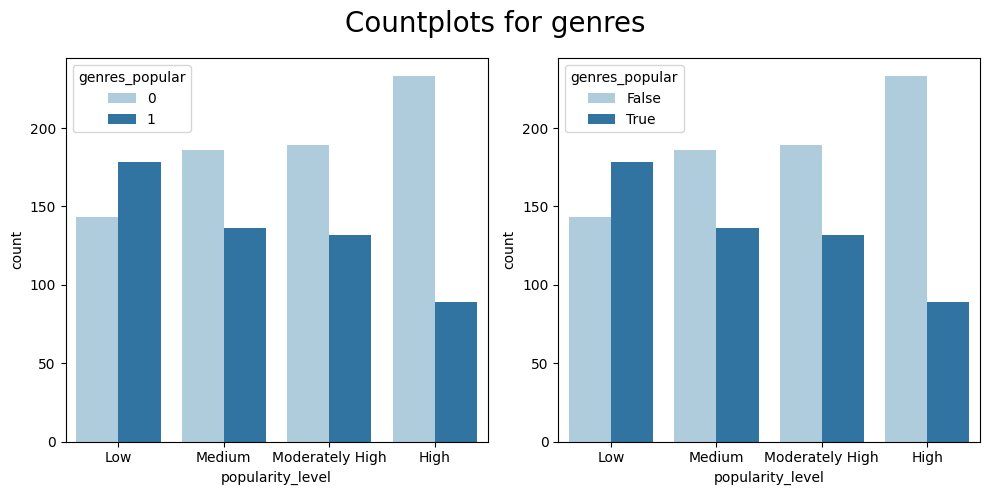

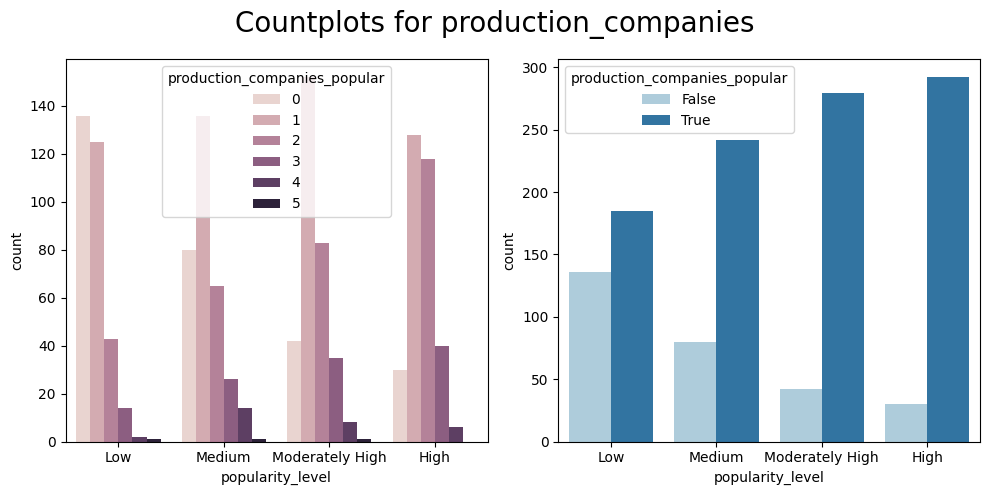

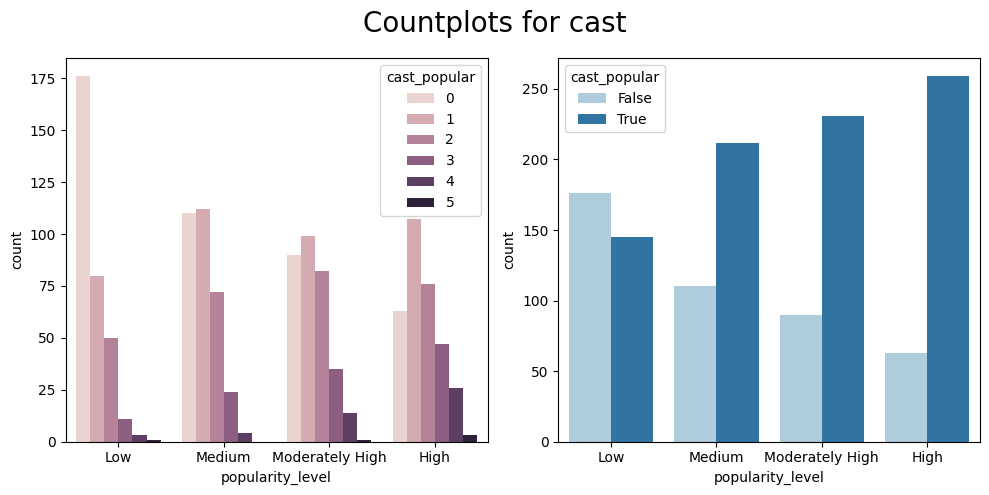

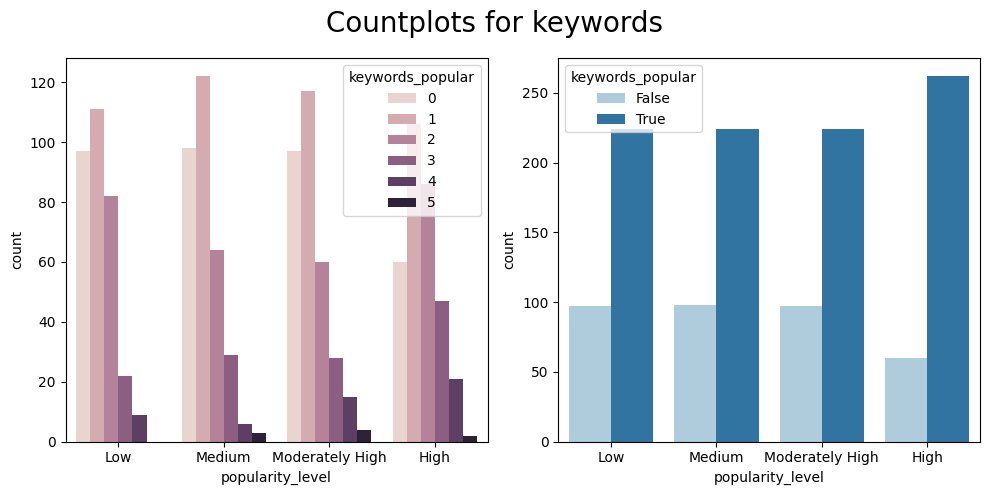

In [128]:
for attribute in ["genres", "production_companies","cast","keywords"]:

    custom_order=["Low","Medium","Moderately High","High"]
    sns.set_palette('Paired')
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    sns.countplot(x=dataset["popularity_level"], hue=dataset[attribute+"_popular"], ax=axes[0],order=custom_order)
    fig.suptitle('Countplots for targets', fontsize=20)
    plt.tight_layout()

    sns.set_palette('Paired')
    sns.countplot(x=dataset["popularity_level"], hue=dataset[attribute+"_popular"]>0, ax=axes[1],order=custom_order)
    fig.suptitle('Countplots for '+attribute, fontsize=20)
    plt.tight_layout()


### Ordinal encoding with popularity_level

In [169]:
dict_pop_order={"Low":0,"Medium":1,"Moderately High":2,"High":3}
dataset["popularity_level_oridnal"]=dataset["popularity_level"].apply(lambda x : dict_pop_order[x])

### Target encoding with director

In [203]:
X_test=dataset.drop("revenue",axis=1)
y_test=dataset["revenue"]

In [218]:
enc = TargetEncoder(cols=["director"], min_samples_leaf=10, smoothing=10).fit(X_test, y_test)
test["director_name"]=dataset["director"]
plot_test=test[["director","director_name"]].drop_duplicates()

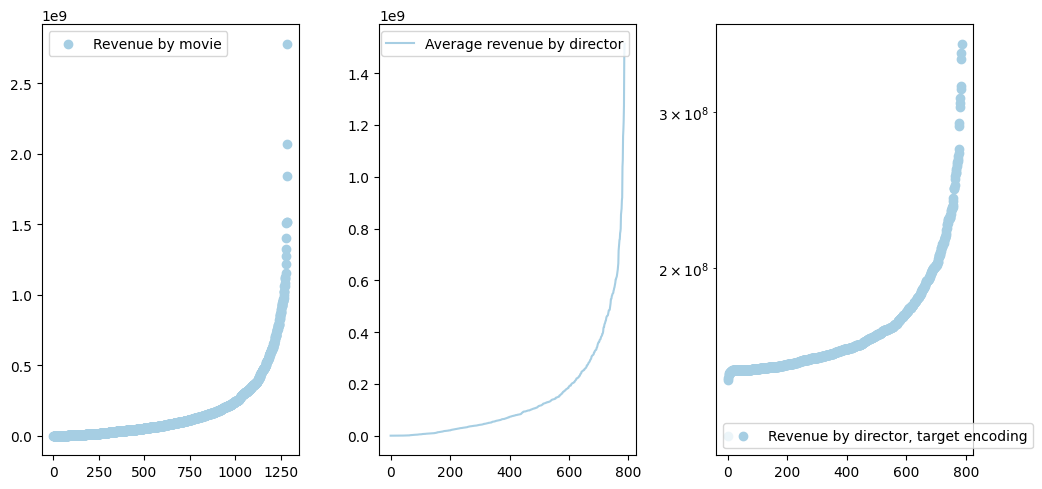

In [231]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

axes[0].scatter(range(len(dataset)),dataset.sort_values(by="revenue")["revenue"],label="Revenue by movie")
plt.yscale("log")

plot_test_bis=dataset.groupby("director")["revenue"].agg("mean").reset_index()
axes[1].plot(range(len(plot_test_bis)),plot_test_bis.sort_values("revenue")["revenue"],label="Average revenue by director")


axes[2].scatter(range(len(set(test["director"]))),test.sort_values(by="director")["director"].drop_duplicates(),label="Revenue by director, target encoding")

plt.tight_layout()
axes[0].legend()
axes[1].legend()
axes[2].legend()


In [ ]:
enc = TargetEncoder(cols=["director"], min_samples_leaf=10, smoothing=10).fit(X_test, y_test)
test["director_name"]=dataset["director"]
plot_test=test[["director","director_name"]].drop_duplicates()

In [233]:
dataset["director_target"]=test["director"]

In [234]:
dataset.head(5)

,index,Unnamed: 0,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,keywords,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj,profit,popularity_level,genres_popular,production_companies_popular,cast_popular,keywords_popular,popularity_level_oridnal,director_target
0,0,0,135397,tt0369610,32.985763,150000000.0,1.513529e+09,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,monster|dna|tyrannosaurus rex|velociraptor|island,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,2015-06-09,5562,6.5,2015,1.379999e+08,1.392446e+09,1.363529e+09,High,0,3,0,2,3,3.503096e+08
1,1,1,76341,tt1392190,28.419936,150000000.0,3.784364e+08,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,future|chase|post-apocalyptic|dystopia|australia,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,2015-05-13,6185,7.1,2015,1.379999e+08,3.481613e+08,2.284364e+08,High,0,1,2,3,3,1.888246e+08
2,2,2,262500,tt2908446,13.112507,110000000.0,2.952382e+08,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,based on novel|revolution|dystopia|sequel|dyst...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,2015-03-18,2480,6.3,2015,1.012000e+08,2.716190e+08,1.852382e+08,High,0,1,1,3,3,1.766285e+08
3,3,3,140607,tt2488496,11.173104,200000000.0,2.068178e+09,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,http://www.starwars.com/films/star-wars-episod...,J.J. Abrams,Every generation has a story.,android|spaceship|jedi|space opera|3d,Thirty years after defeating the Galactic Empi...,136,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,2015-12-15,5292,7.5,2015,1.839999e+08,1.902723e+09,1.868178e+09,High,0,1,1,1,3,2.894557e+08
4,4,4,168259,tt2820852,9.335014,190000000.0,1.506249e+09,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,http://www.furious7.com/,James Wan,Vengeance Hits Home,car race|speed|revenge|suspense|car,Deckard Shaw seeks revenge against Dominic Tor...,137,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,2015-04-01,2947,7.3,2015,1.747999e+08,1.385749e+09,1.316249e+09,High,0,3,4,2,3,2.283256e+08


### Other ideas
- Month/Season influence 

### Columns selection

In [235]:
columns_selected=["popularity","budget","revenue","runtime","vote_count","vote_average","release_year","genres_popular","production_companies_popular","cast_popular","keywords_popular","popularity_level_oridnal","director_target"]

In [236]:
dataset_treated=dataset[columns_selected]

In [238]:
dataset_treated.head()

,popularity,budget,revenue,runtime,vote_count,vote_average,release_year,genres_popular,production_companies_popular,cast_popular,keywords_popular,popularity_level_oridnal,director_target
0,32.985763,150000000.0,1.513529e+09,124,5562,6.5,2015,0,3,0,2,3,3.503096e+08
1,28.419936,150000000.0,3.784364e+08,120,6185,7.1,2015,0,1,2,3,3,1.888246e+08
2,13.112507,110000000.0,2.952382e+08,119,2480,6.3,2015,0,1,1,3,3,1.766285e+08
3,11.173104,200000000.0,2.068178e+09,136,5292,7.5,2015,0,1,1,1,3,2.894557e+08
4,9.335014,190000000.0,1.506249e+09,137,2947,7.3,2015,0,3,4,2,3,2.283256e+08


## Decision Tree

In [239]:
X_train, X_test, y_train, y_test = train_test_split(dataset_treated.drop("revenue",axis=1),dataset_treated["revenue"] , test_size=0.2, random_state=0)

In [240]:
param_grid = {
    'max_depth': [3, 5, 10,20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    "max_features":[None,"sqrt"],
    "criterion":["squared_error","friedman_mse"]}
tree_regressor=DecisionTreeRegressor(random_state=0)
grid_search = GridSearchCV(estimator=tree_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')


In [241]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=0),
             param_grid={'criterion': ['squared_error', 'friedman_mse'],
                         'max_depth': [3, 5, 10, 20],
                         'max_features': [None, 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='neg_mean_squared_error')

In [242]:
grid_search.best_params_

{'criterion': 'squared_error',
 'max_depth': 5,
 'max_features': None,
 'min_samples_leaf': 2,
 'min_samples_split': 10}

In [251]:
mean_scores_array=grid_search.cv_results_['mean_test_score'].reshape(len(param_grid['max_depth']),len(param_grid['min_samples_split']),len(param_grid['min_samples_leaf']),len(param_grid['max_features']),len(param_grid['criterion']))

In [285]:
grid_search.best_score_

-1.613798234759074e+16

In [286]:
grid_max_depth_min_samples=mean_scores_array.max(axis=(2,3,4))

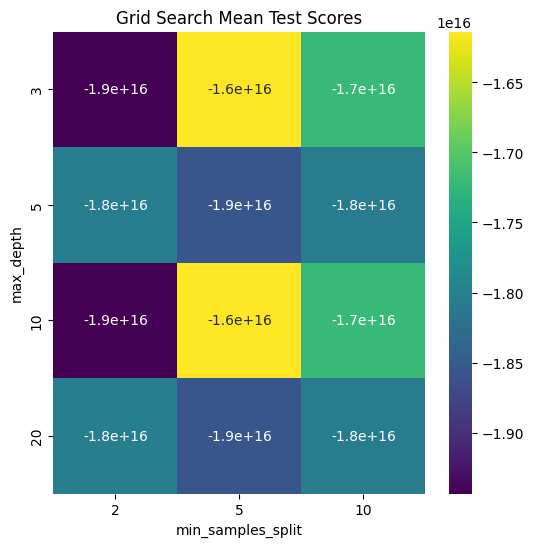

In [288]:

plt.figure(figsize=(6, 6))
sns.heatmap(grid_max_depth_min_samples, annot=True, fmt='.1e', 
            xticklabels=param_grid['min_samples_split'], yticklabels=param_grid['max_depth'],cmap="viridis")
plt.xlabel('min_samples_split')
plt.ylabel('max_depth')
plt.title('Grid Search Mean Test Scores')
plt.show()


In [290]:
y_pred = grid_search.best_estimator_.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error Decision Tree:", mse)

Mean Squared Error: 2.8107327614860892e+16


In [327]:
baseline_model=LinearRegression()
baseline_model.fit(X_train,y_train)
mse=mean_squared_error(y_test,baseline_model.predict(X_test))
print("Mean Squared Error Linear Regression:", mse)

Mean Squared Error Linear Regression: 1.315875709053588e+16


In [292]:
feature_importances = grid_search.best_estimator_.feature_importances_

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, 'popularity'),
  Text(1, 0, 'budget'),
  Text(2, 0, 'runtime'),
  Text(3, 0, 'vote_count'),
  Text(4, 0, 'vote_average'),
  Text(5, 0, 'release_year'),
  Text(6, 0, 'genres_popular'),
  Text(7, 0, 'production_companies_popular'),
  Text(8, 0, 'cast_popular'),
  Text(9, 0, 'keywords_popular'),
  Text(10, 0, 'popularity_level_oridnal'),
  Text(11, 0, 'director_target')])

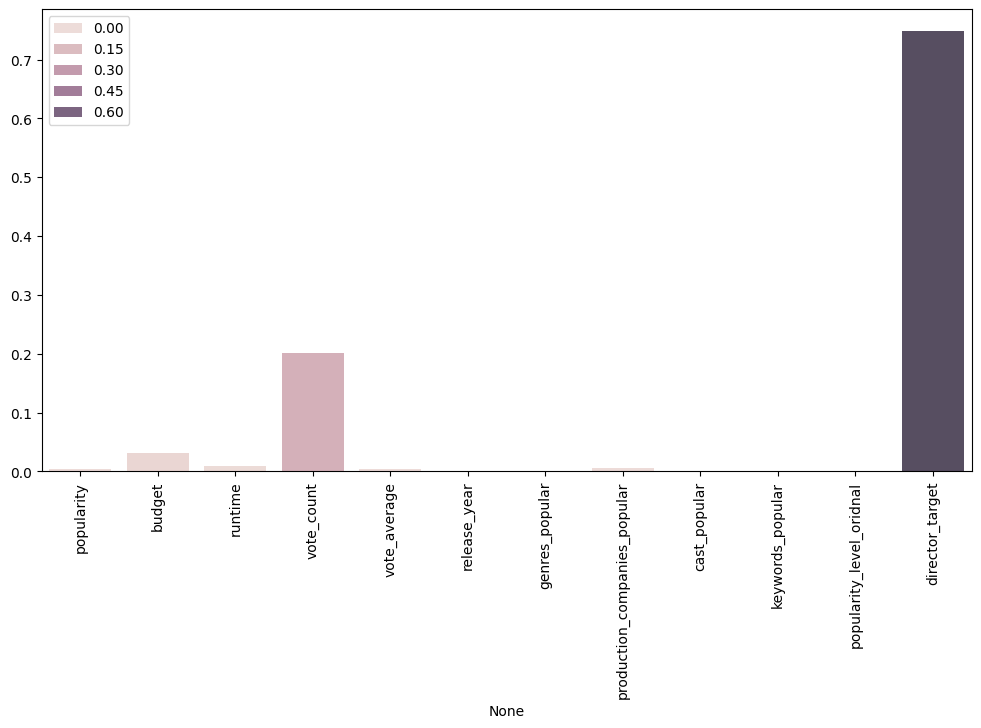

In [325]:
plt.figure(figsize=(12,6))
sns.barplot(x=dataset_treated.drop("revenue",axis=1).columns,y=feature_importances, alpha=0.8,hue=feature_importances)
plt.xticks(rotation=90)

### Test without director target encoded attribute

In [332]:
X_train, X_test, y_train, y_test = train_test_split(dataset_treated.drop(["revenue","director_target"],axis=1),dataset_treated["revenue"] , test_size=0.2, random_state=0)

In [334]:
param_grid = {
    'max_depth': [3, 5, 10,20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    "max_features":[None,"sqrt"],
    "criterion":["squared_error","friedman_mse"]}
tree_regressor=DecisionTreeRegressor(random_state=0)
grid_search = GridSearchCV(estimator=tree_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)
grid_search.best_params_

{'criterion': 'squared_error',
 'max_depth': 5,
 'max_features': None,
 'min_samples_leaf': 4,
 'min_samples_split': 10}

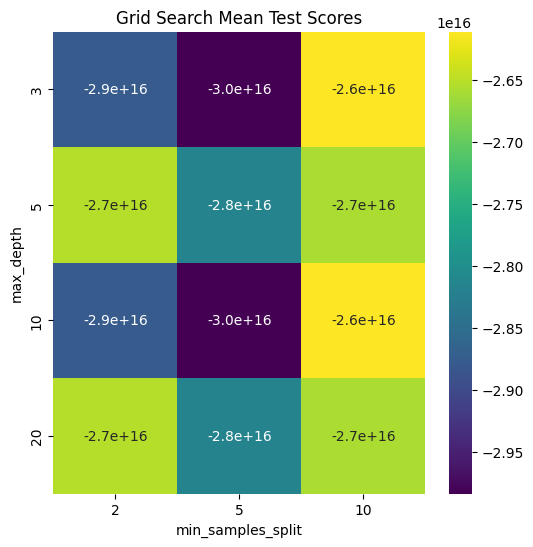

Mean Squared Error Decision Tree: 1.9721996587340624e+16
Mean Squared Error Linear Regression: 1.7880864146101296e+16


In [335]:
mean_scores_array=grid_search.cv_results_['mean_test_score'].reshape(len(param_grid['max_depth']),len(param_grid['min_samples_split']),len(param_grid['min_samples_leaf']),len(param_grid['max_features']),len(param_grid['criterion']))

grid_max_depth_min_samples=mean_scores_array.max(axis=(2,3,4))

plt.figure(figsize=(6, 6))
sns.heatmap(grid_max_depth_min_samples, annot=True, fmt='.1e', 
            xticklabels=param_grid['min_samples_split'], yticklabels=param_grid['max_depth'],cmap="viridis")
plt.xlabel('min_samples_split')
plt.ylabel('max_depth')
plt.title('Grid Search Mean Test Scores')
plt.show()

y_pred = grid_search.best_estimator_.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error Decision Tree:", mse)
baseline_model=LinearRegression()
baseline_model.fit(X_train,y_train)
mse=mean_squared_error(y_test,baseline_model.predict(X_test))
print("Mean Squared Error Linear Regression:", mse)

Reduced difference between Decisicion Tree and Linear Regression performance. (pb overfitting apparently)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, 'popularity'),
  Text(1, 0, 'budget'),
  Text(2, 0, 'runtime'),
  Text(3, 0, 'vote_count'),
  Text(4, 0, 'vote_average'),
  Text(5, 0, 'release_year'),
  Text(6, 0, 'genres_popular'),
  Text(7, 0, 'production_companies_popular'),
  Text(8, 0, 'cast_popular'),
  Text(9, 0, 'keywords_popular'),
  Text(10, 0, 'popularity_level_oridnal')])

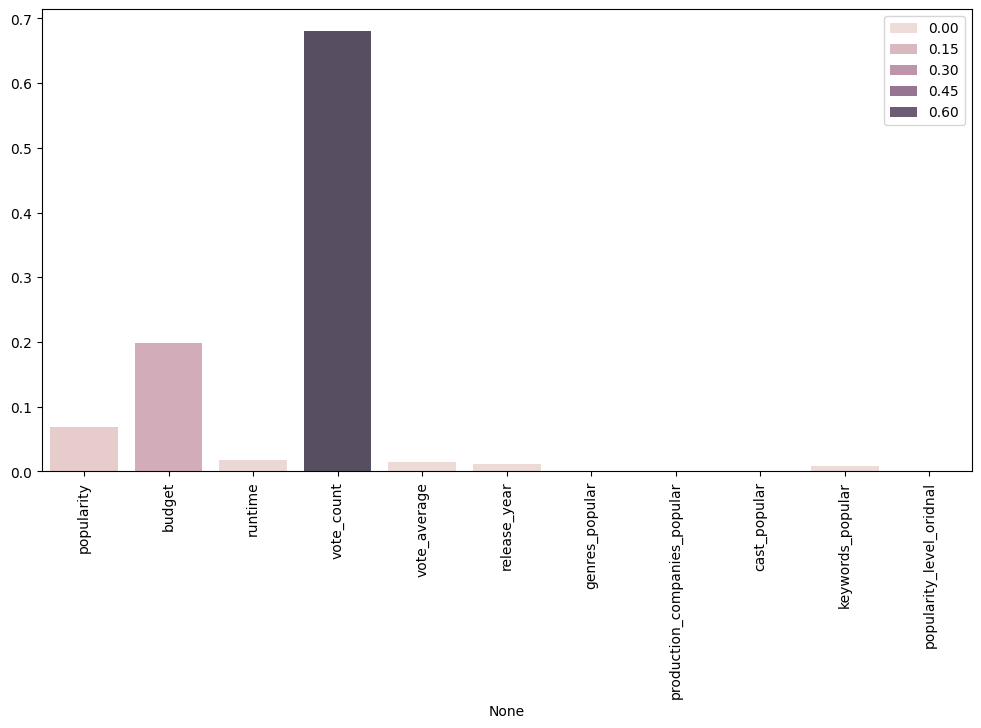

In [336]:
feature_importances = grid_search.best_estimator_.feature_importances_
plt.figure(figsize=(12,6))
sns.barplot(x=dataset_treated.drop(["revenue","director_target"],axis=1).columns,y=feature_importances, alpha=0.8,hue=feature_importances)
plt.xticks(rotation=90)

## Random Forest

In [362]:
X_train, X_test, y_train, y_test = train_test_split(dataset_treated.drop(["revenue","director_target","vote_count"],axis=1),dataset_treated["revenue"] , test_size=0.2, random_state=0)

In [363]:
param_grid = {
    "n_estimators":[20,50,100],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    "max_features":[None,"sqrt"],
    "criterion":["squared_error","friedman_mse"],
    "n_jobs":[16]}
tree_regressor=RandomForestRegressor(random_state=0)
grid_search = GridSearchCV(estimator=tree_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error',verbose=2)


In [364]:
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV] END criterion=squared_error, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=20, n_jobs=16; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=20, n_jobs=16; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=20, n_jobs=16; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=20, n_jobs=16; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=20, n_jobs=16; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50, n_jobs=16; total time=   0.0s
[CV] END cri

{'criterion': 'squared_error',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 50,
 'n_jobs': 16}

Mean Squared Error Decision Tree: 1.783223811251504e+16
Mean Squared Error Linear Regression: 2.230419163801839e+16


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


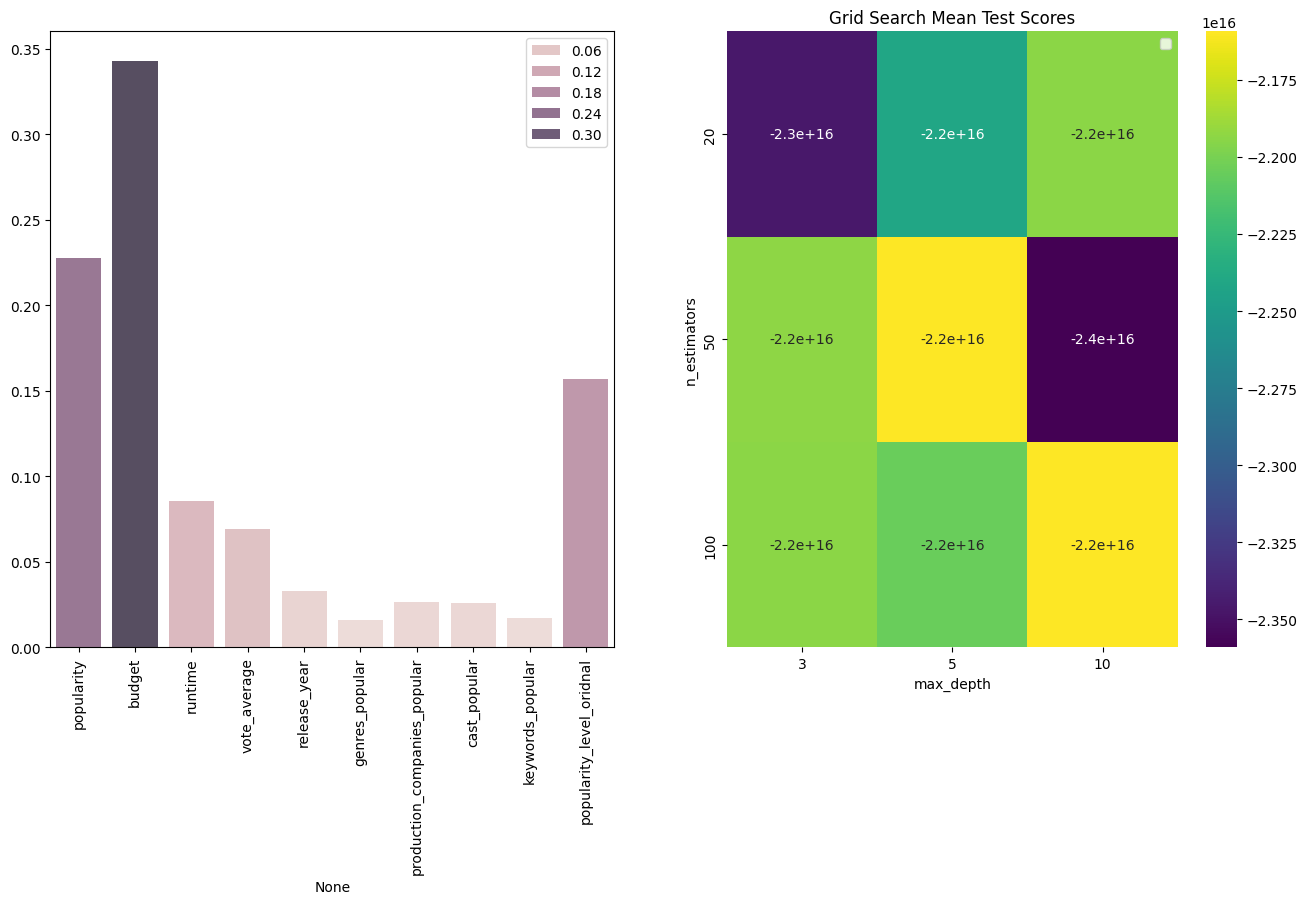

In [382]:
mean_scores_array=grid_search.cv_results_['mean_test_score'].reshape(len(param_grid['n_estimators']),len(param_grid['max_depth']),len(param_grid['min_samples_split']),len(param_grid["min_samples_leaf"]),len(param_grid['max_features']),len(param_grid['criterion']),len(param_grid['n_jobs']))

grid_max_depth_min_samples=mean_scores_array.max(axis=(2,3,4,5,6))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))



y_pred = grid_search.best_estimator_.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error Decision Tree:", mse)
baseline_model=LinearRegression()
baseline_model.fit(X_train,y_train)
mse=mean_squared_error(y_test,baseline_model.predict(X_test))
print("Mean Squared Error Linear Regression:", mse)

feature_importances = grid_search.best_estimator_.feature_importances_

sns.barplot(x=dataset_treated.drop(["revenue","director_target","vote_count"],axis=1).columns,y=feature_importances, alpha=0.8,hue=feature_importances,ax=ax1)
ax1.tick_params(axis='x',rotation=90)



sns.heatmap(grid_max_depth_min_samples, annot=True, fmt='.1e', 
            xticklabels=param_grid['max_depth'], yticklabels=param_grid['n_estimators'],cmap="viridis",ax=ax2)
plt.xlabel('max_depth')
plt.ylabel('n_estimators')
plt.title('Grid Search Mean Test Scores')
plt.legend()
plt.show()

## Tests with logarithm of revenue and budget

In [383]:
dataset_treated["revenue"]=dataset_treated["revenue"].apply(np.log)
dataset_treated["budget"]=dataset_treated["budget"].apply(np.log)

C:\Users\rapha\AppData\Local\Temp\ipykernel_35368\3598593319.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_treated["revenue"]=dataset_treated["revenue"].apply(np.log)
C:\Users\rapha\AppData\Local\Temp\ipykernel_35368\3598593319.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_treated["budget"]=dataset_treated["budget"].apply(np.log)


In [384]:
X_train, X_test, y_train, y_test = train_test_split(dataset_treated.drop(["revenue","director_target","vote_count"],axis=1),dataset_treated["revenue"] , test_size=0.2, random_state=0)

In [385]:
param_grid = {
    "n_estimators":[20,50,100],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    "max_features":[None,"sqrt"],
    "criterion":["squared_error","friedman_mse"],
    "n_jobs":[16]}
tree_regressor=RandomForestRegressor(random_state=0)
grid_search = GridSearchCV(estimator=tree_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error',verbose=2)


In [386]:
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV] END criterion=squared_error, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=20, n_jobs=16; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=20, n_jobs=16; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=20, n_jobs=16; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=20, n_jobs=16; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=20, n_jobs=16; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50, n_jobs=16; total time=   0.0s
[CV] END cri

{'criterion': 'squared_error',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 100,
 'n_jobs': 16}

Mean Squared Error Decision Tree: 1.8773069962781086
Mean Squared Error Linear Regression: 1.8088355095688446


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


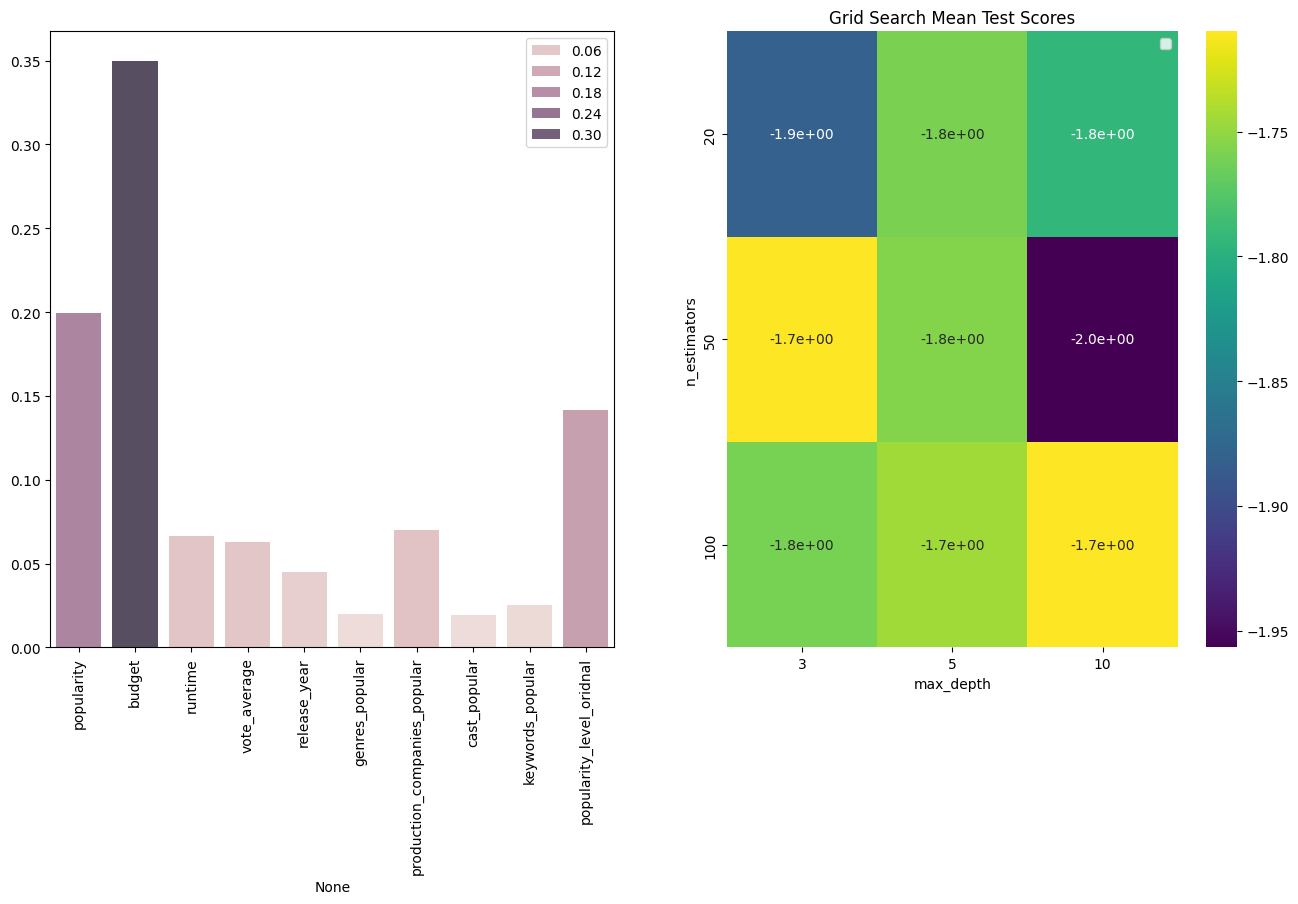

In [388]:
mean_scores_array=grid_search.cv_results_['mean_test_score'].reshape(len(param_grid['n_estimators']),len(param_grid['max_depth']),len(param_grid['min_samples_split']),len(param_grid["min_samples_leaf"]),len(param_grid['max_features']),len(param_grid['criterion']),len(param_grid['n_jobs']))

grid_max_depth_min_samples=mean_scores_array.max(axis=(2,3,4,5,6))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))



y_pred = grid_search.best_estimator_.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error Decision Tree:", mse)
baseline_model=LinearRegression()
baseline_model.fit(X_train,y_train)
mse=mean_squared_error(y_test,baseline_model.predict(X_test))
print("Mean Squared Error Linear Regression:", mse)

feature_importances = grid_search.best_estimator_.feature_importances_

sns.barplot(x=dataset_treated.drop(["revenue","director_target","vote_count"],axis=1).columns,y=feature_importances, alpha=0.8,hue=feature_importances,ax=ax1)
ax1.tick_params(axis='x',rotation=90)



sns.heatmap(grid_max_depth_min_samples, annot=True, fmt='.1e', 
            xticklabels=param_grid['max_depth'], yticklabels=param_grid['n_estimators'],cmap="viridis",ax=ax2)
plt.xlabel('max_depth')
plt.ylabel('n_estimators')
plt.title('Grid Search Mean Test Scores')
plt.legend()
plt.show()

## Working with new preprocessing

In [3]:
dataset=pd.read_csv("processed_dataset.csv")

In [13]:
dataset=dataset.drop(dataset.columns[0],axis=1)

In [14]:
dataset.head(5)

,budget,revenue,runtime,vote_count,vote_average,profit,release_month,tagline length,overview length,num_goodcast,director_quality,production quality,keyword quality,highimpact genre
0,150000000.0,1.513529e+09,124,5562,6.5,1.363529e+09,6,4,26,0,1,0,0,1
1,150000000.0,3.784364e+08,120,6185,7.1,2.284364e+08,5,4,110,1,0,1,1,1
2,165000000.0,6.217525e+08,169,6498,8.0,4.567525e+08,11,12,35,2,0,2,0,1
3,170000000.0,7.733124e+08,121,5612,7.9,6.033124e+08,7,4,28,2,0,2,0,1
4,110000000.0,2.952382e+08,119,2480,6.3,1.852382e+08,3,5,22,0,0,2,0,1


In [15]:
X_train, X_test, y_train, y_test = train_test_split(dataset.drop(["profit","revenue"],axis=1),dataset["profit"] , test_size=0.2, random_state=0)

In [16]:
param_grid = {
    "n_estimators":[20,50,100],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    "max_features":[None,"sqrt"],
    "criterion":["squared_error","friedman_mse"],
    "n_jobs":[16]}
tree_regressor=RandomForestRegressor(random_state=0)
grid_search = GridSearchCV(estimator=tree_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error',verbose=2)


In [17]:
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV] END criterion=squared_error, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=20, n_jobs=16; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=20, n_jobs=16; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=20, n_jobs=16; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=20, n_jobs=16; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=20, n_jobs=16; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50, n_jobs=16; total time=   0.1s
[CV] END cri

{'criterion': 'squared_error',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100,
 'n_jobs': 16}

Mean Squared Error Decision Tree: 1.5572814285713642e+16
Mean Squared Error Linear Regression: 1.8086499092761524e+16


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


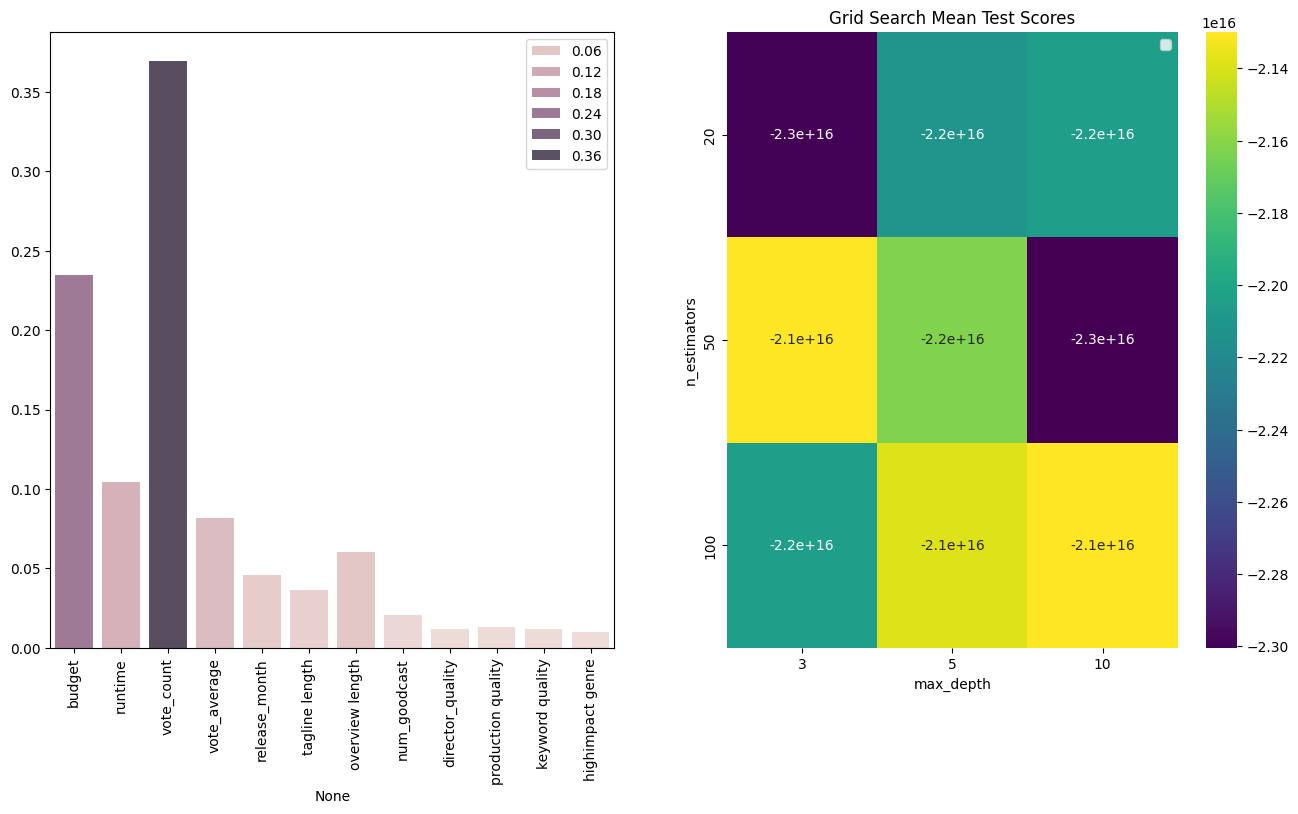

In [19]:
mean_scores_array=grid_search.cv_results_['mean_test_score'].reshape(len(param_grid['n_estimators']),len(param_grid['max_depth']),len(param_grid['min_samples_split']),len(param_grid["min_samples_leaf"]),len(param_grid['max_features']),len(param_grid['criterion']),len(param_grid['n_jobs']))

grid_max_depth_min_samples=mean_scores_array.max(axis=(2,3,4,5,6))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))



y_pred = grid_search.best_estimator_.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error Decision Tree:", mse)
baseline_model=LinearRegression()
baseline_model.fit(X_train,y_train)
mse=mean_squared_error(y_test,baseline_model.predict(X_test))
print("Mean Squared Error Linear Regression:", mse)

feature_importances = grid_search.best_estimator_.feature_importances_

sns.barplot(x=dataset.drop(["revenue","profit"],axis=1).columns,y=feature_importances, alpha=0.8,hue=feature_importances,ax=ax1)
ax1.tick_params(axis='x',rotation=90)



sns.heatmap(grid_max_depth_min_samples, annot=True, fmt='.1e', 
            xticklabels=param_grid['max_depth'], yticklabels=param_grid['n_estimators'],cmap="viridis",ax=ax2)
plt.xlabel('max_depth')
plt.ylabel('n_estimators')
plt.title('Grid Search Mean Test Scores')
plt.legend()
plt.show()

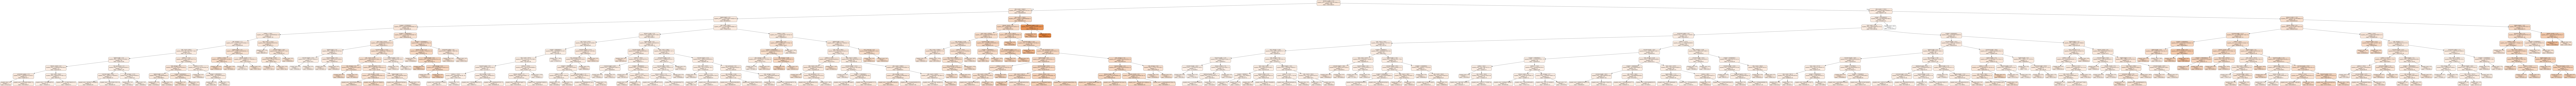

In [35]:
export_graphviz(grid_search.best_estimator_.estimators_[0],out_file='tree.dot',feature_names = dataset.drop(["profit","revenue"],axis=1).columns,
                class_names = ["profit"],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

Image(filename = 'tree.png')

## Classification : Profitable or not ?